In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from Utils.properties import HAC
from rdkit.Chem import MolFromSmiles
import scipy as sp
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles

/home/chaoting/software/miniconda3/envs/py385/lib/python3.8/site-packages/moses/metrics/utils.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _mcf.append(_pains, sort=True)['smarts'].values]


In [2]:
property_list = ['logP', 'tPSA', 'QED']
trg_prop_settings = {
    'logP': [ 1.0,   2.0,  3.0],
    'tPSA': [30.0,  60.0, 90.0],
    'QED' : [ 0.6, 0.725, 0.85],
}
tol = [0.4, 8, 0.03]

In [282]:
def add_hac(df):
    mols = list(map(MolFromSmiles, df['scaffold']))
    df['HAC'] = list(map(HAC, mols))
    return df


def get_trg_prop_list():
    # get property combinations

    prop_set = (trg_prop_settings[p] for p in property_list)
    prop_comb = list(itertools.product(*prop_set))
    trg_prop_list = [list(c) for c in prop_comb]
    # for i in range(len(trg_prop_list)):
    #     print(i, trg_prop_list[i])
    return trg_prop_list


def get_n_train():
    n_train = []
    a = b = c = 0
    trg_prop_list = get_trg_prop_list()
    train = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/train.csv', index_col=[0])

    for i, prop in enumerate(trg_prop_list):
        filtered = train[(prop[0] - tol[0] <= train.logP) & (train.logP <= prop[0] + tol[0])]
        filtered = filtered[(prop[1] - tol[1] <= filtered.tPSA) & (filtered.tPSA <= prop[1] + tol[1])]
        filtered = filtered[(prop[2] - tol[2] <= filtered.QED) & (filtered.QED <= prop[2] + tol[2])]
        n_train.append(len(filtered))
        
        if prop[2] == 0.6:
            a += len(filtered)
        if prop[2] == 0.725:
            b += len(filtered)
        if prop[2] == 0.85:
            c += len(filtered)
    return n_train


def plot3d(prop_name, data, figsize=10, s=1, alpha=0.75,
           cmap='BuGn', levels=20, ax_limits=None, ngrids=20j):

    """
    plot a scattering 3D figure with distributions on
    three planes
    ----------
    prop_name: list
        a list of the three variables
    data: pandas.DataFrame
        a DataFrame recording the points
    figpath: string
        the figure path
    figsize: float, 10
        figure size
    s: float, 1
        the size of each point
    alpha: float, 0.75
        the transparency
    cmap: string, 'RdBu_r'
        the color
    levels: int, 20
        the number of the contour lines
    ax_limits: dict, None
        the limits of the axes in three directions
    ngrids: int, 20
        number of the grids each sides
    """

    assert len(prop_name) == 3

    if ax_limits == None:
        ax_limits = {
            prop_name[0]: [np.floor(data[prop_name[0]].min()),
                           np.ceil(data[prop_name[0]].max())],
            prop_name[1]: [np.floor(data[prop_name[1]].min()),
                           np.ceil(data[prop_name[1]].max())],
            prop_name[2]: [np.floor(data[prop_name[2]].min()),
                           np.ceil(data[prop_name[2]].max())]
        }

    xmin = ax_limits[prop_name[0]][0]
    xmax = ax_limits[prop_name[0]][1]
    ymin = ax_limits[prop_name[1]][0]
    ymax = ax_limits[prop_name[1]][1]
    zmin = ax_limits[prop_name[2]][0]
    zmax = ax_limits[prop_name[2]][1]

    x, y, z = np.mgrid[xmin:xmax:ngrids,
                       ymin:ymax:ngrids,
                       zmin:zmax:ngrids]


    # Convert DataFrame to Numpy array
    data = data.to_numpy().T

    print(data)

    # Compute kernel density
    kernel = sp.stats.gaussian_kde(data)
    positions = np.vstack((x.ravel(), y.ravel(), z.ravel()))
    density = np.reshape(kernel(positions).T, x.shape)

    d1, d2, d3 = np.unravel_index(density.argmax(), density.shape)
    highest_freq_values = [x[d1,d2,d3], y[d1,d2,d3], z[d1,d2,d3]]

    # plot data
    ax = plt.subplot(projection='3d')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.set_size_inches(15, 15)

    # Set figure size
    # fig = plt.gcf()
    # fig.set_size_inches(figsize, figsize, figsize)

    ax.scatter(data[0, :], data[1, :], data[2, :], s=s, marker='o', c='k')

    ax.set_xlabel(prop_name[0], fontsize=32)
    ax.set_ylabel(prop_name[1], fontsize=32)
    ax.set_zlabel(prop_name[2], fontsize=32)

    ax.xaxis.labelpad = 26
    ax.yaxis.labelpad = 26
    ax.zaxis.labelpad = 26

    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    ax.tick_params(axis='z', labelsize=24)

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.set_zlim((zmin, zmax))
    
    print('plot projection of density onto x-axis')
    plotdat = np.sum(density, axis=0)  # summing up density along z-axis
    plotdat = plotdat / np.max(plotdat)
    ploty, plotz = np.mgrid[ymin:ymax:ngrids, zmin:zmax:ngrids]
    
    colorx = ax.contourf(plotdat, ploty, plotz, levels=levels,
                        alpha=alpha, cmap=cmap, offset=xmin, zdir='x')

    print('plot projection of density onto y-axis')
    plotdat = np.sum(density, axis=1)  # summing up density along y-axis
    plotdat = plotdat / np.max(plotdat)
    plotx, plotz = np.mgrid[xmin:xmax:ngrids, zmin:zmax:ngrids]
    colory = ax.contourf(plotx, plotdat, plotz, levels=levels,
                        alpha=alpha, cmap=cmap, offset=ymax, zdir='y')

    print('plot projection of density onto z-axis')
    plotdat = np.sum(density, axis=2)
    plotdat = plotdat / np.max(plotdat)
    plotx, ploty = np.mgrid[xmin:xmax:ngrids, ymin:ymax:ngrids]
    colorz = ax.contourf(plotx, ploty, plotdat, levels=levels,
                        alpha=alpha, cmap=cmap, offset=zmin, zdir='z')

    cbar = fig.colorbar(colorx, ax=ax, shrink=0.5, pad=0.1)
    cbar.ax.tick_params(labelsize=20)

    plt.tight_layout()
    # fig.savefig(figpath)
    
    return highest_freq_values


def get_mol(smi_or_mol):
    """convert smiles to mol. (copied from molgpt)
    """
    if isinstance(smi_or_mol, str):
        if len(smi_or_mol) == 0:
            return None
        mol = Chem.MolFromSmiles(smi_or_mol)
        if mol is None:
            return None
        try:
            Chem.SanitizeMol(mol)
        except ValueError:
            return None
        return mol
    return smi_or_mol


def murcko_scaffold(smi_or_mol):
    mol = get_mol(smi_or_mol)
    if mol is None:
        return None
    return MurckoScaffoldSmiles(mol=mol)


def get_average_metric_from_all_models(datatype, molgpt=False):
    file_folder = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/'

    if molgpt:
        n = 5
        model1 = 'scacvaetfv31-beta0.01-warmup15000_molgpt-20'
        model2 = 'scacvaetfv32-beta0.01-warmup15000_molgpt-20'
        model3 = 'scacvaetfv33-beta0.01-warmup15000_molgpt-20'    
    else:
        n = 100
        model1 = 'scacvaetfv31-beta0.01-warmup15000-17'
        model2 = 'scacvaetfv32-beta0.01-warmup15000-19'
        model3 = 'scacvaetfv3-beta0.01-warmup15000-17'
    
    n_train = get_n_train()
    all_met = None
    for sid in np.arange(0, n):
        df_list = []
        for model_name in (model1, model2, model3):
            file_path = os.path.join(file_folder, model_name, datatype, f's{sid}_metric.csv')
            df = pd.read_csv(file_path, index_col=[0])
            if not molgpt:
                df['n_train'] = n_train
            scaffold = df['scaffold'].to_list()
            df_numeric = df.select_dtypes(include=['float32', 'float64', 'int32', 'int64'])
            df_list.append(df_numeric)

        met = pd.concat(df_list).groupby(level=0).mean()
        met.insert(0, 'scaffold', scaffold)

        if sid == 0:
            all_met = met
        else:
            all_met = pd.concat([all_met, met], axis=0)
    all_met = all_met.reset_index(drop=True)
    all_met = add_hac(all_met)
    return all_met


In [40]:
## check

# worst
smiles = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv31-beta0.01-warmup15000-17/test_scaffolds/s9_p1.0-30.0-0.6_gen.csv', index_col=[0])
scaffolds = list(map(murcko_scaffold,smiles))
scaffolds = [s for s in scaffolds if s is not None]

### Metric value (unique, intDiv) vs. HAC of the scaffold

In [41]:
file_folder = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/'
model1 = 'scacvaetfv31-beta0.01-warmup15000-17'
model2 = 'scacvaetfv32-beta0.01-warmup15000-19'
model3 = 'scacvaetfv3-beta0.01-warmup15000-17'

In [42]:
trg_prop_list = get_trg_prop_list()

In [34]:
train = get_average_metric_from_all_models(datatype='train')
testsca = get_average_metric_from_all_models(datatype='test_scaffolds')

In [51]:
train_hac = train.groupby(by=['scaffold', 'HAC']).mean().reset_index()
testsca_hac = testsca.groupby(by=['scaffold', 'HAC']).mean().reset_index()

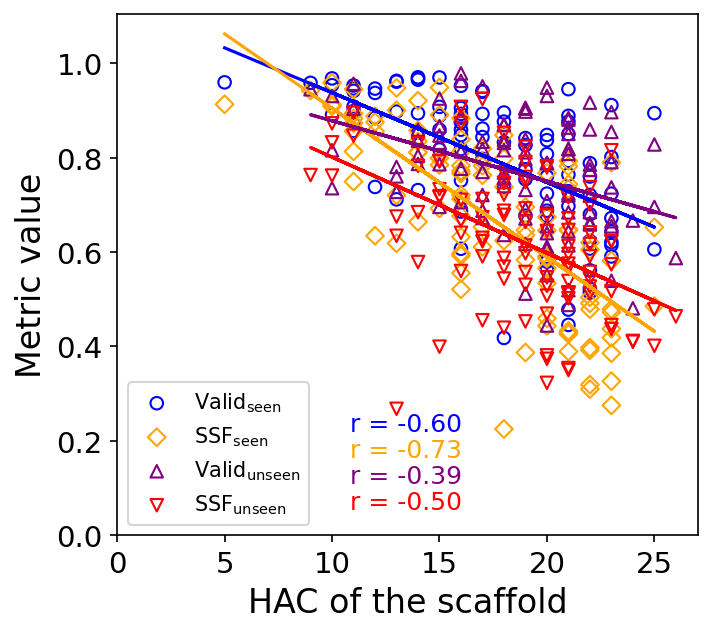

In [52]:
hac1 = train_hac['HAC']
valid1 = train_hac['valid']
ssf1 = train_hac['SSF']

hac2 = testsca_hac['HAC']
valid2 = testsca_hac['valid']
ssf2 = testsca_hac['SSF']

plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(hac1, valid1, label=r'$\mathdefault{Valid}_{\mathdefault{seen}}$', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(hac1, ssf1, label=r'$\mathdefault{SSF}_{\mathdefault{seen}}$', marker='D', facecolors='none', edgecolors='orange')
plt.scatter(hac2, valid2, label=r'$\mathdefault{Valid}_{\mathdefault{unseen}}$', marker='^', facecolors='none', edgecolors='purple')
plt.scatter(hac2, ssf2, label=r'$\mathdefault{SSF}_{\mathdefault{unseen}}$', marker='v', facecolors='none', edgecolors='red')

plt.xlabel('HAC of the scaffold', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
# plt.legend(fontsize=10)
plt.legend(fontsize=10, loc='lower left')

m1, b1 = np.polyfit(hac1, valid1, deg=1)
m2, b2 = np.polyfit(hac1, ssf1, deg=1)
plt.plot(hac1, m1*np.array(hac1) + b1, color='blue')
plt.plot(hac1, m2*np.array(hac1) + b2, color='orange')

m1, b1 = np.polyfit(hac2, valid2, deg=1)
m2, b2 = np.polyfit(hac2, ssf2, deg=1)
plt.plot(hac2, m1*np.array(hac2) + b1, color='purple')
plt.plot(hac2, m2*np.array(hac2) + b2, color='red')


r1_unique = np.corrcoef(hac1, valid1)[0, 1]
r1_intdiv = np.corrcoef(hac1, ssf1)[0, 1]
r2_unique = np.corrcoef(hac2, valid2)[0, 1]
r2_intdiv = np.corrcoef(hac2, ssf2)[0, 1]

plt.text(0.40, 0.20, rf'r = {r1_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.text(0.40, 0.15, rf'r = {r1_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='orange')
plt.text(0.40, 0.10, rf'r = {r2_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='purple')
plt.text(0.40, 0.05, rf'r = {r2_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='red')

plt.xticks(np.arange(0, 25+1, 5), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)

plt.show()

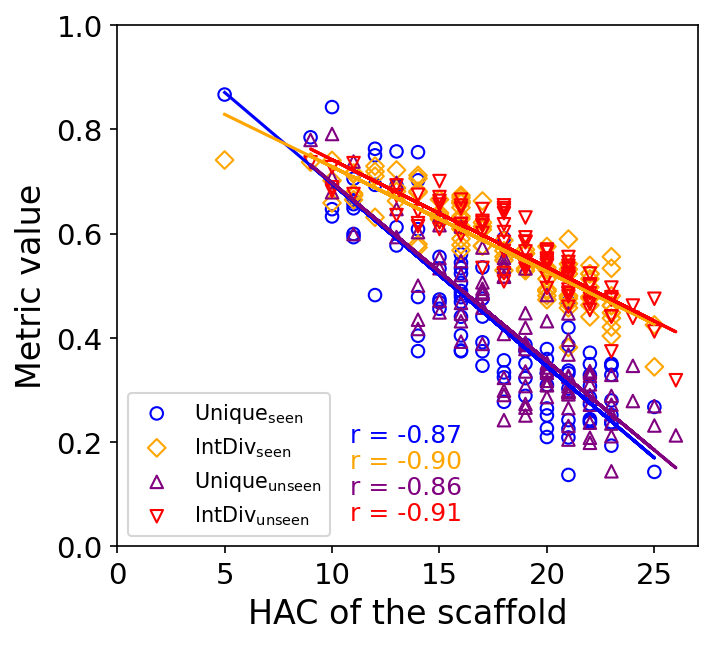

In [53]:
hac1 = train_hac['HAC']
unique1 = train_hac['unique']
intdiv1 = train_hac['intDiv']

hac2 = testsca_hac['HAC']
unique2 = testsca_hac['unique']
intdiv2 = testsca_hac['intDiv']

plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(hac1, unique1, label=r'$\mathdefault{Unique}_{\mathdefault{seen}}$', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(hac1, intdiv1, label=r'$\mathdefault{IntDiv}_{\mathdefault{seen}}$', marker='D', facecolors='none', edgecolors='orange')
plt.scatter(hac2, unique2, label=r'$\mathdefault{Unique}_{\mathdefault{unseen}}$', marker='^', facecolors='none', edgecolors='purple')
plt.scatter(hac2, intdiv2, label=r'$\mathdefault{IntDiv}_{\mathdefault{unseen}}$', marker='v', facecolors='none', edgecolors='red')

plt.xlabel('HAC of the scaffold', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
# plt.legend(fontsize=10)
plt.legend(fontsize=10, loc='lower left')

m1, b1 = np.polyfit(hac1, unique1, deg=1)
m2, b2 = np.polyfit(hac1, intdiv1, deg=1)
plt.plot(hac1, m1*np.array(hac1) + b1, color='blue')
plt.plot(hac1, m2*np.array(hac1) + b2, color='orange')

m1, b1 = np.polyfit(hac2, unique2, deg=1)
m2, b2 = np.polyfit(hac2, intdiv2, deg=1)
plt.plot(hac2, m1*np.array(hac2) + b1, color='purple')
plt.plot(hac2, m2*np.array(hac2) + b2, color='red')


r1_unique = np.corrcoef(hac1, unique1)[0, 1]
r1_intdiv = np.corrcoef(hac1, intdiv1)[0, 1]
r2_unique = np.corrcoef(hac2, unique2)[0, 1]
r2_intdiv = np.corrcoef(hac2, intdiv2)[0, 1]

plt.text(0.40, 0.20, rf'r = {r1_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.text(0.40, 0.15, rf'r = {r1_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='orange')
plt.text(0.40, 0.10, rf'r = {r2_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='purple')
plt.text(0.40, 0.05, rf'r = {r2_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='red')

plt.xticks(np.arange(0, 25+1, 5), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)

plt.show()

In [54]:
train_prop = train.groupby(by=['logP', 'tPSA', 'QED']).mean().reset_index(drop=False)
testsca_prop = testsca.groupby(by=['logP', 'tPSA', 'QED']).mean().reset_index(drop=False)


In [55]:
n_train = get_n_train()

train_prop['n_train'] = n_train
testsca_prop['n_train'] = n_train

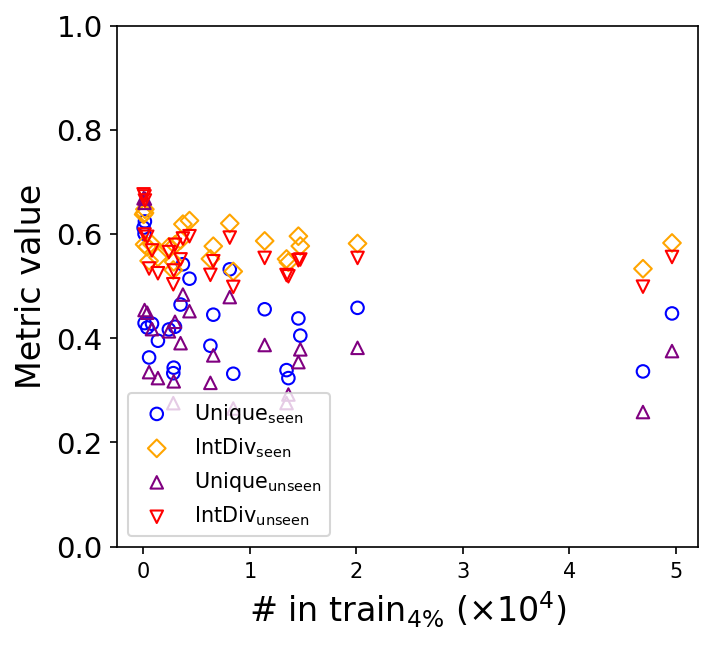

In [56]:
x1 = train_prop['n_train'] / 10000
unique1 = train_prop['unique']
intdiv1 = train_prop['intDiv']

x2 = testsca_prop['n_train'] / 10000
unique2 = testsca_prop['unique']
intdiv2 = testsca_prop['intDiv']

plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(x1, unique1, label=r'$\mathdefault{Unique}_{\mathdefault{seen}}$', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(x1, intdiv1, label=r'$\mathdefault{IntDiv}_{\mathdefault{seen}}$', marker='D', facecolors='none', edgecolors='orange')
plt.scatter(x2, unique2, label=r'$\mathdefault{Unique}_{\mathdefault{unseen}}$', marker='^', facecolors='none', edgecolors='purple')
plt.scatter(x2, intdiv2, label=r'$\mathdefault{IntDiv}_{\mathdefault{unseen}}$', marker='v', facecolors='none', edgecolors='red')

plt.xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.legend(fontsize=10, loc='lower left')
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)

plt.show()

In [58]:
train_prop[train_prop.n_train < 2000]

,logP,tPSA,QED,valid,unique,novel,intDiv,sim,SSF,sim80,...,tPSA-MSE,tPSA-MAE,tPSA-SD,QED-MSE,QED-MAE,QED-SD,valid_in_tolerance,unique_in_tolerance,n_train,HAC
0,1.0,30.0,0.600,0.411180,0.612097,0.997731,0.637629,0.533265,0.194739,0.212325,...,4.403852,9.266826,7.666179,0.114959,0.132986,0.079379,2.940000,1.583333,13,17.36
1,1.0,30.0,0.725,0.407843,0.600343,0.997416,0.640540,0.530742,0.185470,0.206374,...,4.055012,9.156898,7.807534,0.006018,0.069205,0.072717,14.226667,4.256667,102,17.36
2,1.0,30.0,0.850,0.335540,0.624164,0.997911,0.647515,0.509455,0.143689,0.170320,...,2.498133,9.336130,8.166085,-0.093733,0.095965,0.069041,5.720000,2.663333,136,17.36
3,1.0,60.0,0.600,0.780247,0.363032,0.991684,0.548487,0.843329,0.637837,0.682584,...,-0.814265,6.765466,7.158815,0.142099,0.152707,0.075740,46.233333,17.083333,530,17.36
6,1.0,90.0,0.600,0.919013,0.395143,0.991380,0.555364,0.940572,0.832501,0.872269,...,-5.109594,7.541186,7.519797,0.112906,0.126801,0.071534,59.366667,30.693333,1359,17.36
9,2.0,30.0,0.600,0.632710,0.429009,0.996560,0.580044,0.711940,0.444857,0.472053,...,7.495853,9.901014,6.341064,0.138723,0.149442,0.072117,25.116667,10.293333,106,17.36
10,2.0,30.0,0.725,0.619247,0.420418,0.995355,0.575221,0.709253,0.435875,0.465499,...,7.624360,10.022321,6.386192,0.035526,0.071969,0.062221,33.293333,13.923333,354,17.36
18,3.0,30.0,0.600,0.754643,0.427790,0.994308,0.579898,0.799340,0.586320,0.618282,...,8.920697,10.402640,5.470001,0.129331,0.143464,0.073927,56.036667,23.960000,804,17.36


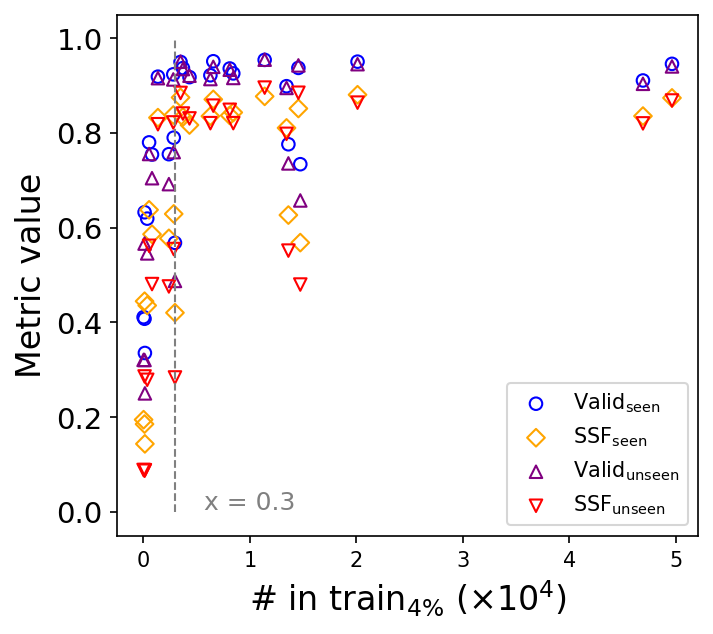

In [64]:
x1 = train_prop['n_train'] / 10000
unique1 = train_prop['valid']
intdiv1 = train_prop['SSF']

x2 = testsca_prop['n_train'] / 10000
unique2 = testsca_prop['valid']
intdiv2 = testsca_prop['SSF']

plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(x1, unique1, label=r'$\mathdefault{Valid}_{\mathdefault{seen}}$', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(x1, intdiv1, label=r'$\mathdefault{SSF}_{\mathdefault{seen}}$', marker='D', facecolors='none', edgecolors='orange')
plt.scatter(x2, unique2, label=r'$\mathdefault{Valid}_{\mathdefault{unseen}}$', marker='^', facecolors='none', edgecolors='purple')
plt.scatter(x2, intdiv2, label=r'$\mathdefault{SSF}_{\mathdefault{unseen}}$', marker='v', facecolors='none', edgecolors='red')

plt.plot([0.3, 0.3], [0, 1], color='gray', linewidth=1, linestyle='dashed')

plt.xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
# plt.legend(fontsize=10, loc='lower left')
plt.legend(fontsize=10, loc='lower right')

plt.text(0.15, 0.05, 'x = 0.3', transform=plt.gca().transAxes, fontsize=12, color='gray')

# plt.xticks(np.arange(0, 10000, 100), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)

plt.show()

In [126]:
train_prop_met.head()

,logP,tPSA,QED,valid,unique,novel,intDiv,sim,SSF,sim80,...,logP-SD,tPSA-MSE,tPSA-MAE,tPSA-SD,QED-MSE,QED-MAE,QED-SD,n_within_tolerance,HAC,n_train
0,1.0,30.0,0.600,0.411180,0.612097,0.997731,0.637629,0.533265,0.194739,0.212325,...,0.568009,4.403852,9.266826,7.666179,0.114959,0.132986,0.079379,6.76,17.36,13
1,1.0,30.0,0.725,0.407843,0.600343,0.997416,0.640540,0.530742,0.185470,0.206374,...,0.571760,4.055012,9.156898,7.807534,0.006018,0.069205,0.072717,33.10,17.36,102
2,1.0,30.0,0.850,0.335540,0.624164,0.997911,0.647515,0.509455,0.143689,0.170320,...,0.604325,2.498133,9.336130,8.166085,-0.093733,0.095965,0.069041,16.23,17.36,136
3,1.0,60.0,0.600,0.780247,0.363032,0.991684,0.548487,0.843329,0.637837,0.682584,...,0.447083,-0.814265,6.765466,7.158815,0.142099,0.152707,0.075740,48.43,17.36,530
4,1.0,60.0,0.725,0.790170,0.343448,0.989871,0.546470,0.838549,0.629228,0.674640,...,0.451059,-0.477597,6.814969,7.182361,0.040475,0.077827,0.064065,68.69,17.36,2842


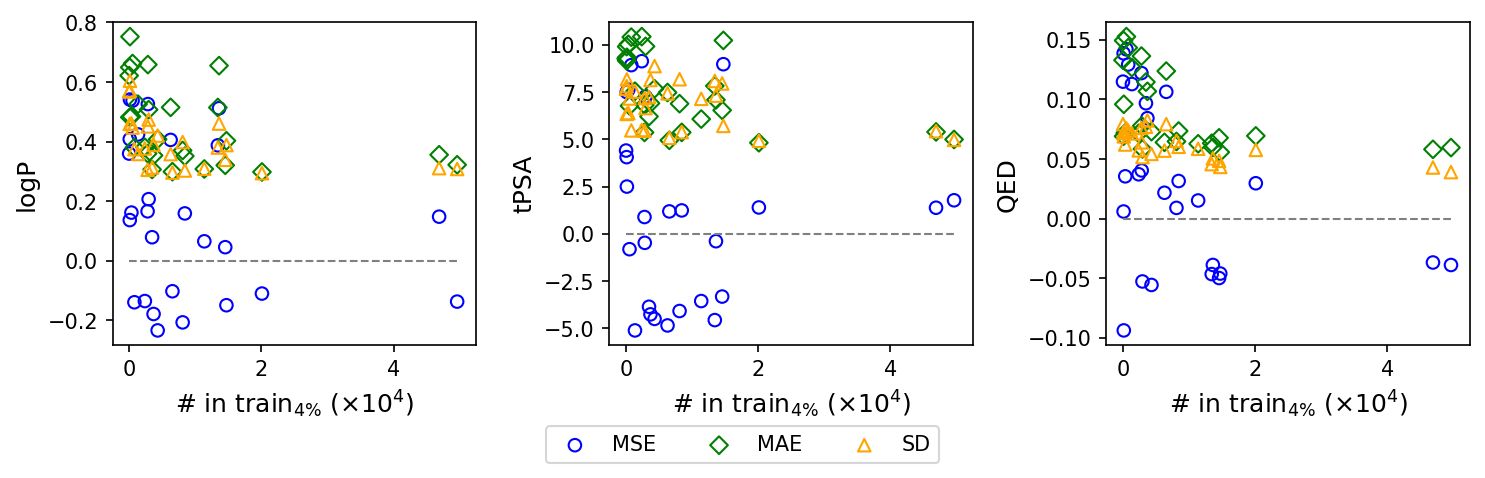

In [162]:
x = train_prop_met['n_train'] / 10000

# Plot 1: logP
y1_mse = train_prop_met['logP-MSE']
y1_mae = train_prop_met['logP-MAE']
y1_sd = train_prop_met['logP-SD']

# Plot 2: tPSA
y2_mse = train_prop_met['tPSA-MSE']
y2_mae = train_prop_met['tPSA-MAE']
y2_sd = train_prop_met['tPSA-SD']

# Plot 3: QED
y3_mse = train_prop_met['QED-MSE']
y3_mae = train_prop_met['QED-MAE']
y3_sd = train_prop_met['QED-SD']

fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=150)

# Plot 1: logP
axes[0].scatter(x, y1_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[0].scatter(x, y1_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[0].scatter(x, y1_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[0].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[0].set_ylabel('logP', fontsize=12)
axes[0].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 2: tPSA
axes[1].scatter(x, y2_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[1].scatter(x, y2_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[1].scatter(x, y2_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[1].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[1].set_ylabel('tPSA', fontsize=12)
axes[1].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 3: QED
axes[2].scatter(x, y3_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[2].scatter(x, y3_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[2].scatter(x, y3_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[2].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[2].set_ylabel('QED', fontsize=12)
axes[2].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Common legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
plt.show()

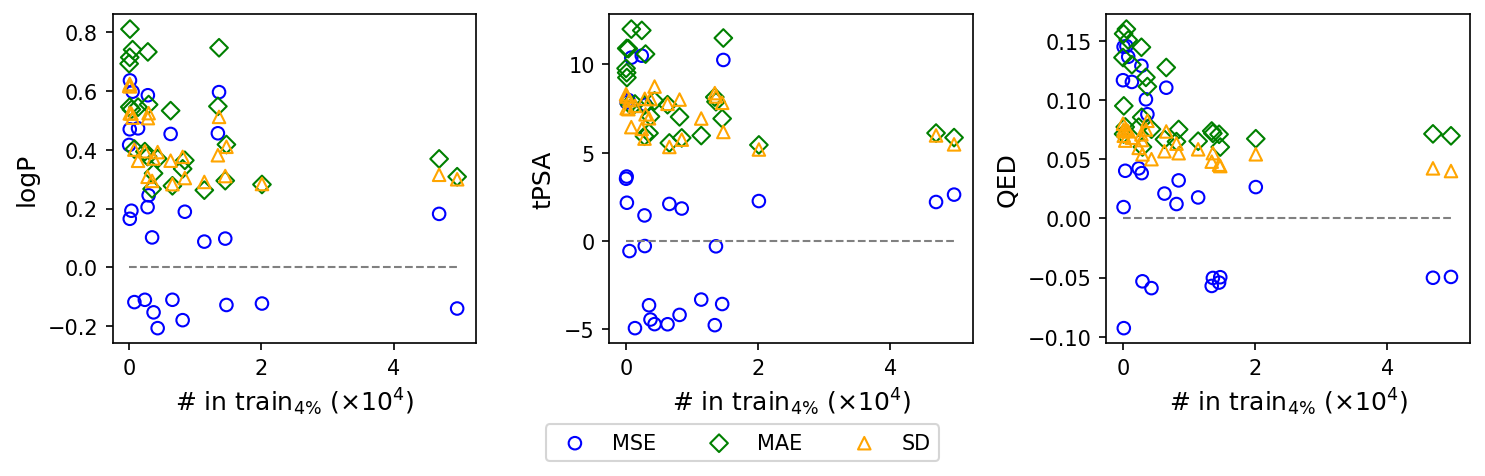

In [163]:
x = test_prop_met['n_train'] / 10000

# Plot 1: logP
y1_mse = test_prop_met['logP-MSE']
y1_mae = test_prop_met['logP-MAE']
y1_sd = test_prop_met['logP-SD']

# Plot 2: tPSA
y2_mse = test_prop_met['tPSA-MSE']
y2_mae = test_prop_met['tPSA-MAE']
y2_sd = test_prop_met['tPSA-SD']

# Plot 3: QED
y3_mse = test_prop_met['QED-MSE']
y3_mae = test_prop_met['QED-MAE']
y3_sd = test_prop_met['QED-SD']

fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=150)

# Plot 1: logP
axes[0].scatter(x, y1_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[0].scatter(x, y1_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[0].scatter(x, y1_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[0].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[0].set_ylabel('logP', fontsize=12)
axes[0].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 2: tPSA
axes[1].scatter(x, y2_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[1].scatter(x, y2_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[1].scatter(x, y2_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[1].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[1].set_ylabel('tPSA', fontsize=12)
axes[1].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 3: QED
axes[2].scatter(x, y3_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[2].scatter(x, y3_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[2].scatter(x, y3_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[2].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[2].set_ylabel('QED', fontsize=12)
axes[2].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Common legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
plt.show()

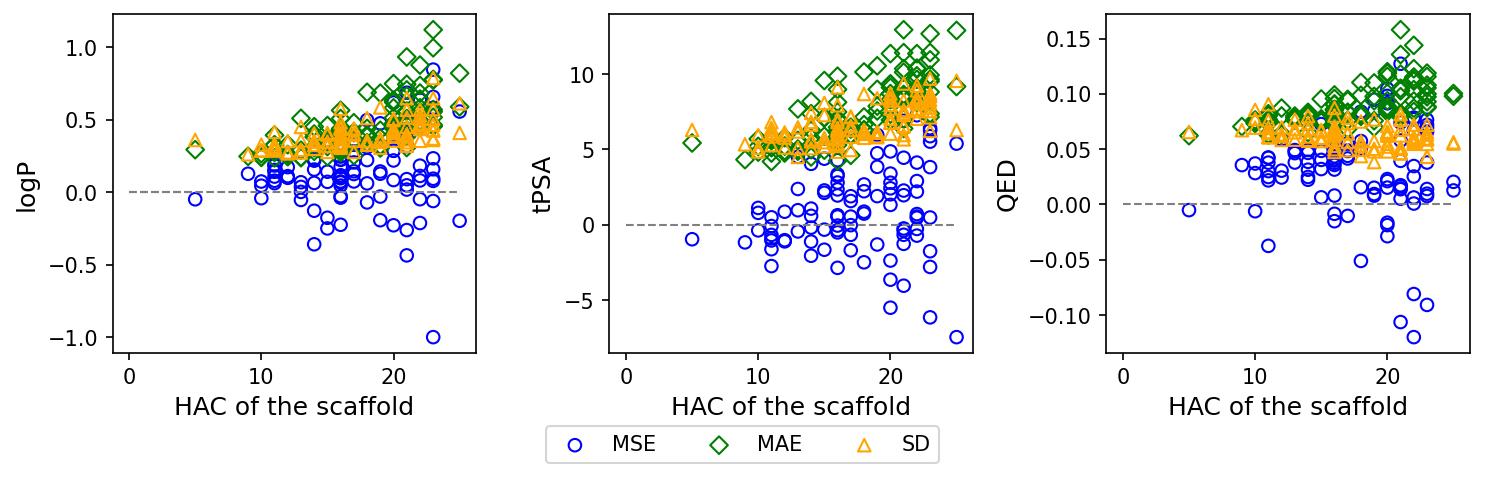

In [171]:
x = train_mean_met['HAC']

# Plot 1: logP
y1_mse = train_mean_met['logP-MSE']
y1_mae = train_mean_met['logP-MAE']
y1_sd = train_mean_met['logP-SD']

# Plot 2: tPSA
y2_mse = train_mean_met['tPSA-MSE']
y2_mae = train_mean_met['tPSA-MAE']
y2_sd = train_mean_met['tPSA-SD']

# Plot 3: QED
y3_mse = train_mean_met['QED-MSE']
y3_mae = train_mean_met['QED-MAE']
y3_sd = train_mean_met['QED-SD']

fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=150)

# Plot 1: logP
axes[0].scatter(x, y1_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[0].scatter(x, y1_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[0].scatter(x, y1_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[0].set_xlabel('HAC of the scaffold', fontsize=12)
axes[0].set_ylabel('logP', fontsize=12)
axes[0].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')
axes[0].plot([0, 25], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 2: tPSA
axes[1].scatter(x, y2_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[1].scatter(x, y2_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[1].scatter(x, y2_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[1].set_xlabel('HAC of the scaffold', fontsize=12)
axes[1].set_ylabel('tPSA', fontsize=12)
axes[1].plot([0, 25], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 3: QED
axes[2].scatter(x, y3_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[2].scatter(x, y3_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[2].scatter(x, y3_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[2].set_xlabel('HAC of the scaffold', fontsize=12)
axes[2].set_ylabel('QED', fontsize=12)
axes[2].plot([0, 25], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Common legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
plt.show()

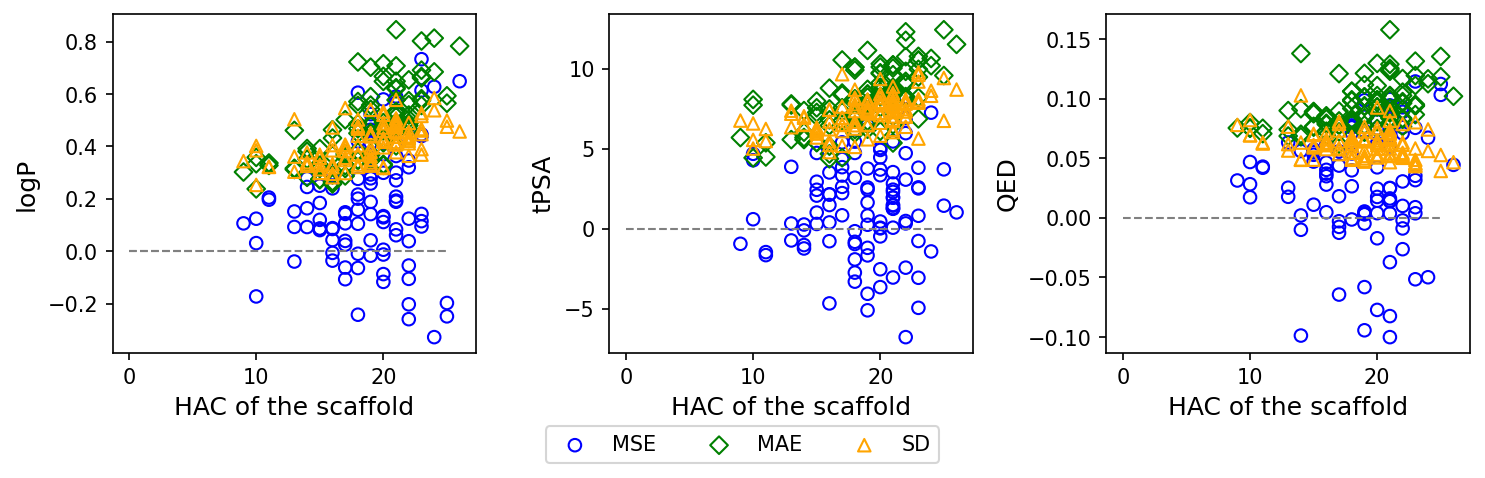

In [172]:
x = test_mean_met['HAC']

# Plot 1: logP
y1_mse = test_mean_met['logP-MSE']
y1_mae = test_mean_met['logP-MAE']
y1_sd = test_mean_met['logP-SD']

# Plot 2: tPSA
y2_mse = test_mean_met['tPSA-MSE']
y2_mae = test_mean_met['tPSA-MAE']
y2_sd = test_mean_met['tPSA-SD']

# Plot 3: QED
y3_mse = test_mean_met['QED-MSE']
y3_mae = test_mean_met['QED-MAE']
y3_sd = test_mean_met['QED-SD']

fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=150)

# Plot 1: logP
axes[0].scatter(x, y1_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[0].scatter(x, y1_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[0].scatter(x, y1_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[0].set_xlabel('HAC of the scaffold', fontsize=12)
axes[0].set_ylabel('logP', fontsize=12)
axes[0].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')
axes[0].plot([0, 25], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 2: tPSA
axes[1].scatter(x, y2_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[1].scatter(x, y2_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[1].scatter(x, y2_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[1].set_xlabel('HAC of the scaffold', fontsize=12)
axes[1].set_ylabel('tPSA', fontsize=12)
axes[1].plot([0, 25], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 3: QED
axes[2].scatter(x, y3_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[2].scatter(x, y3_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[2].scatter(x, y3_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[2].set_xlabel('HAC of the scaffold', fontsize=12)
axes[2].set_ylabel('QED', fontsize=12)
axes[2].plot([0, 25], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Common legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
plt.show()

### Case Study
- search for the best and worst one

In [416]:
train_avg_metric = get_average_metric_from_all_models(datatype='train')
testsca_avg_metric = get_average_metric_from_all_models(datatype='test_scaffolds')

# train - valid found: 110, unique found: 49
# scaffold test - valid found: 84, unique found: 30

In [419]:
train_avg_metric.sort_values('unique_in_tolerance')

,scaffold,logP,tPSA,QED,valid,unique,novel,intDiv,sim,SSF,...,tPSA-MSE,tPSA-MAE,tPSA-SD,QED-MSE,QED-MAE,QED-SD,valid_in_tolerance,unique_in_tolerance,n_train,HAC
1349,O=C(Nc1ccc2[nH]ncc2c1)c1ccccn1,3.0,90.0,0.850,0.964000,0.460797,0.999241,0.639423,0.964789,0.867268,...,-2.845829,6.130176,7.411431,-0.077455,0.078070,0.029349,0.000000,0.000000,4322.0,18
1819,O=C(c1ccc(NC2CC2)nc1)N(CC1CCCCC1)C1CC1,2.0,30.0,0.725,0.420667,0.627141,0.999008,0.712550,0.538728,0.035536,...,2.520581,7.564199,8.187455,0.037825,0.072770,0.079155,0.000000,0.000000,354.0,23
1820,O=C(c1ccc(NC2CC2)nc1)N(CC1CCCCC1)C1CC1,2.0,30.0,0.850,0.348333,0.556182,1.000000,0.681454,0.587940,0.026616,...,4.238453,7.663047,7.782661,-0.058813,0.067515,0.067912,0.000000,0.000000,2959.0,23
1821,O=C(c1ccc(NC2CC2)nc1)N(CC1CCCCC1)C1CC1,2.0,60.0,0.600,0.794333,0.099707,0.985517,0.251252,0.948660,0.826593,...,-9.772140,12.448404,8.749444,0.249680,0.250041,0.037927,0.000000,0.000000,2801.0,23
875,O=C(Cn1cccn1)N1CCNCC1,2.0,30.0,0.850,0.965667,0.413346,0.981611,0.673044,0.990650,0.976855,...,11.248848,11.286030,1.617822,-0.008733,0.010505,0.019132,0.000000,0.000000,2959.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1589,c1ccc(Cn2ccnc2)cc1,3.0,60.0,0.850,0.989333,0.932613,0.997832,0.758539,0.970801,0.949537,...,-0.486935,3.387748,4.462532,-0.008680,0.032284,0.045020,481.333333,440.000000,49624.0,12
1607,c1ccc2[nH]ccc2c1,2.0,60.0,0.850,0.985000,0.871065,0.967368,0.762732,0.995274,0.990865,...,-0.213712,2.957731,4.046985,-0.009280,0.033310,0.046660,552.000000,461.333333,46898.0,9
1616,c1ccc2[nH]ccc2c1,3.0,60.0,0.850,0.980667,0.946975,0.988891,0.780703,0.994874,0.989107,...,-0.798706,3.071190,4.218622,-0.013827,0.035906,0.051799,510.000000,474.333333,49624.0,9
2156,O=C(NCc1ccccc1)c1ccccc1,3.0,60.0,0.850,0.996000,0.862457,0.907877,0.724766,0.994281,0.989291,...,-0.082184,3.422653,4.055548,0.006565,0.025819,0.034867,620.000000,517.666667,49624.0,16


In [11]:
print('# that more than 200 unique molecules were found:', len(testsca_avg_metric[testsca_avg_metric.unique_in_tolerance >= 200]))

# that more than 200 unique molecules were found: 90


In [16]:
worst_case_scaffold = 'O=C(NCC1CCc2ccccc2O1)c1cnc(-c2cccnc2)nc1'
best_case_scaffold = 'c1ccc2c(c1)CCS2'

In [18]:
worst_sorted = testsca_avg_metric[testsca_avg_metric.scaffold==worst_case_scaffold].sort_values('unique_in_tolerance', ascending=False)
# logP, tPSA, QED = 2.66, 77.0, 0.786
worst_sorted.head()

,scaffold,logP,tPSA,QED,valid,unique,novel,intDiv,sim,SSF,...,tPSA-MSE,tPSA-MAE,tPSA-SD,QED-MSE,QED-MAE,QED-SD,valid_in_tolerance,unique_in_tolerance,n_train,HAC
268,O=C(NCC1CCc2ccccc2O1)c1cnc(-c2cccnc2)nc1,3.0,90.0,0.725,0.905667,0.098978,0.996942,0.277432,0.956388,0.878146,...,-7.009648,10.673124,9.884250,0.030725,0.040908,0.036270,144.0,19.333333,8103.0,26
259,O=C(NCC1CCc2ccccc2O1)c1cnc(-c2cccnc2)nc1,2.0,90.0,0.725,0.946000,0.037846,0.986111,0.183596,0.960694,0.850364,...,-6.696933,11.076360,8.103765,0.046194,0.047062,0.023787,160.0,6.666667,11381.0,26
267,O=C(NCC1CCc2ccccc2O1)c1cnc(-c2cccnc2)nc1,3.0,90.0,0.600,0.936667,0.096628,1.000000,0.271255,0.956395,0.877439,...,-6.080267,10.039070,10.024025,0.140675,0.147187,0.061275,11.0,1.333333,3705.0,26
243,O=C(NCC1CCc2ccccc2O1)c1cnc(-c2cccnc2)nc1,1.0,30.0,0.600,0.104000,0.827126,1.000000,0.647177,0.413890,0.000000,...,-3.558800,6.581806,7.170069,0.153249,0.171291,0.109549,0.0,0.000000,13.0,26
257,O=C(NCC1CCc2ccccc2O1)c1cnc(-c2cccnc2)nc1,2.0,60.0,0.850,0.755333,0.042454,1.000000,0.163935,0.951332,0.845734,...,9.066403,9.478095,4.208695,-0.118283,0.120200,0.035264,0.0,0.000000,46898.0,26


In [19]:
best_sorted = testsca_avg_metric[testsca_avg_metric.scaffold==best_case_scaffold].sort_values('unique_in_tolerance')
best_sorted.head()

,scaffold,logP,tPSA,QED,valid,unique,novel,intDiv,sim,SSF,...,tPSA-MSE,tPSA-MAE,tPSA-SD,QED-MSE,QED-MAE,QED-SD,valid_in_tolerance,unique_in_tolerance,n_train,HAC
1810,c1ccc2c(c1)CCS2,1.0,30.0,0.725,0.873667,0.595834,0.999349,0.684936,0.796094,0.652281,...,2.521560,6.660818,7.699075,0.044001,0.071306,0.067431,0.333333,0.333333,102.0,9
1809,c1ccc2c(c1)CCS2,1.0,30.0,0.600,0.900667,0.611766,1.000000,0.681806,0.774653,0.615878,...,0.986300,5.504627,6.607919,0.153007,0.158992,0.080751,2.000000,2.000000,13.0,9
1811,c1ccc2c(c1)CCS2,1.0,30.0,0.850,0.824000,0.497095,1.000000,0.658089,0.745547,0.570632,...,4.262900,7.921786,8.573252,-0.027668,0.033026,0.041225,13.333333,9.666667,136.0,9
1819,c1ccc2c(c1)CCS2,2.0,30.0,0.725,0.935333,0.695403,0.999489,0.715680,0.899943,0.801056,...,2.801142,5.666169,6.784271,0.013258,0.081418,0.091709,31.666667,27.333333,354.0,9
1812,c1ccc2c(c1)CCS2,1.0,60.0,0.600,0.963333,0.684179,0.999553,0.716392,0.917520,0.832119,...,0.366138,4.642641,5.728514,0.127809,0.140387,0.094169,88.333333,48.000000,530.0,9


In [12]:
avg_by_prop = testsca_avg_metric.groupby(by=['logP', 'tPSA', 'QED']).mean().reset_index()
avg_by_hac = testsca_avg_metric.groupby(by=['HAC']).mean().reset_index()

In [13]:
# best
sid = 74
logP = 3.0
tPSA = 60.0
QED = 0.85

best1 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv31-beta0.01-warmup15000-17/test_scaffolds/s{sid}_p{logP:.1f}-{tPSA:.1f}-{QED:.2f}_prop.csv', index_col=[0])
best2 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv32-beta0.01-warmup15000-19/test_scaffolds/s{sid}_p{logP:.1f}-{tPSA:.1f}-{QED:.2f}_prop.csv', index_col=[0])
best3 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv3-beta0.01-warmup15000-17/test_scaffolds/s{sid}_p{logP:.1f}-{tPSA:.1f}-{QED:.2f}_prop.csv', index_col=[0])

best = pd.concat([best1, best2, best3], axis=0)
best = best[['logP', 'tPSA', 'QED']]


In [14]:
# worst
sid = 9
logP = 1.0
tPSA = 30.0
QED = 0.6

worst1 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv31-beta0.01-warmup15000-17/test_scaffolds/s{sid}_p{logP:.1f}-{tPSA:.1f}-{QED:.1f}_prop.csv', index_col=[0])
worst2 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv32-beta0.01-warmup15000-19/test_scaffolds/s{sid}_p{logP:.1f}-{tPSA:.1f}-{QED:.1f}_prop.csv', index_col=[0])
worst3 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv3-beta0.01-warmup15000-17/test_scaffolds/s{sid}_p{logP:.1f}-{tPSA:.1f}-{QED:.1f}_prop.csv', index_col=[0])

worst = pd.concat([worst1, worst2, worst3], axis=0)
worst = worst[['logP', 'tPSA', 'QED']]


In [32]:

def plot3d(prop_name, data, trg_p, figsize=10, s=1, alpha=0.75,
           cmap='BuGn', levels=20, ax_limits=None, ngrids=20j):

    """
    plot a scattering 3D figure with distributions on
    three planes
    ----------
    prop_name: list
        a list of the three variables
    data: pandas.DataFrame
        a DataFrame recording the points
    figpath: string
        the figure path
    figsize: float, 10
        figure size
    s: float, 1
        the size of each point
    alpha: float, 0.75
        the transparency
    cmap: string, 'RdBu_r'
        the color
    levels: int, 20
        the number of the contour lines
    ax_limits: dict, None
        the limits of the axes in three directions
    ngrids: int, 20
        number of the grids each sides
    """

    assert len(prop_name) == 3

    if ax_limits == None:
        ax_limits = {
            prop_name[0]: [np.floor(data[prop_name[0]].min()),
                           np.ceil(data[prop_name[0]].max())],
            prop_name[1]: [np.floor(data[prop_name[1]].min()),
                           np.ceil(data[prop_name[1]].max())],
            prop_name[2]: [np.floor(data[prop_name[2]].min()),
                           np.ceil(data[prop_name[2]].max())]
        }

    xmin = ax_limits[prop_name[0]][0]
    xmax = ax_limits[prop_name[0]][1]
    ymin = ax_limits[prop_name[1]][0]
    ymax = ax_limits[prop_name[1]][1]
    zmin = ax_limits[prop_name[2]][0]
    zmax = ax_limits[prop_name[2]][1]

    x, y, z = np.mgrid[xmin:xmax:ngrids,
                       ymin:ymax:ngrids,
                       zmin:zmax:ngrids]


    # Convert DataFrame to Numpy array
    data = data.to_numpy().T

    print(data)

    # Compute kernel density
    kernel = sp.stats.gaussian_kde(data)
    positions = np.vstack((x.ravel(), y.ravel(), z.ravel()))
    density = np.reshape(kernel(positions).T, x.shape)

    d1, d2, d3 = np.unravel_index(density.argmax(), density.shape)
    highest_freq_values = [x[d1,d2,d3], y[d1,d2,d3], z[d1,d2,d3]]

    # plot data
    ax = plt.subplot(projection='3d')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.set_size_inches(15, 15)

    # Set figure size
    # fig = plt.gcf()
    # fig.set_size_inches(figsize, figsize, figsize)

    ax.scatter(data[0, :], data[1, :], data[2, :], s=s, marker='o', c='k')

    # xmin, ymin, 0.8 / xmin, ymax, 0.8
    # xmin, 60, ymin / xmin, 60, zmax

    # 3, ymin, zmin / 3, ymin, zmax
    # xmin, ymax, 0.8 / xmax, ymax, 0.8

    # 3, ymin, 0 / 3, ymax, 0
    # xmin, 60, 0 / xmax, 60, 0

    # xy plane
    ax.plot([xmin, xmin], [ymin, ymax], [trg_p[2], trg_p[2]], color='black', linewidth=2)
    ax.plot([xmin, xmin], [trg_p[1], trg_p[1]], [zmin, zmax], color='black',linewidth=2)
    # yz plane
    ax.plot([trg_p[0], trg_p[0]], [ymax, ymax], [zmin, zmax], color='black',linewidth=2)
    ax.plot([xmin, xmax], [ymax, ymax], [trg_p[2], trg_p[2]], color='black',linewidth=2)
    # zx plane
    ax.plot([trg_p[0], trg_p[0]], [ymin, ymax], [zmin, zmin], color='black',linewidth=2)
    ax.plot([xmin, xmax], [trg_p[1], trg_p[1]], [zmin, zmin], color='black',linewidth=2)

    ax.set_xlabel(prop_name[0], fontsize=32)
    ax.set_ylabel(prop_name[1], fontsize=32)
    ax.set_zlabel(prop_name[2], fontsize=32)

    ax.xaxis.labelpad = 26
    ax.yaxis.labelpad = 26
    ax.zaxis.labelpad = 26

    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    ax.tick_params(axis='z', labelsize=24)

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.set_zlim((zmin, zmax))
    
    print('plot projection of density onto x-axis')
    plotdat = np.sum(density, axis=0)  # summing up density along z-axis
    plotdat = plotdat / np.max(plotdat)
    ploty, plotz = np.mgrid[ymin:ymax:ngrids, zmin:zmax:ngrids]
    
    colorx = ax.contourf(plotdat, ploty, plotz, levels=levels,
                        alpha=alpha, cmap=cmap, offset=xmin, zdir='x')

    print('plot projection of density onto y-axis')
    plotdat = np.sum(density, axis=1)  # summing up density along y-axis
    plotdat = plotdat / np.max(plotdat)
    plotx, plotz = np.mgrid[xmin:xmax:ngrids, zmin:zmax:ngrids]
    colory = ax.contourf(plotx, plotdat, plotz, levels=levels,
                        alpha=alpha, cmap=cmap, offset=ymax, zdir='y')

    print('plot projection of density onto z-axis')
    plotdat = np.sum(density, axis=2)
    plotdat = plotdat / np.max(plotdat)
    plotx, ploty = np.mgrid[xmin:xmax:ngrids, ymin:ymax:ngrids]
    colorz = ax.contourf(plotx, ploty, plotdat, levels=levels,
                        alpha=alpha, cmap=cmap, offset=zmin, zdir='z')

    cbar = fig.colorbar(colorx, ax=ax, shrink=0.5, pad=0.1)
    cbar.ax.tick_params(labelsize=20)

    plt.tight_layout()
    # fig.savefig(figpath)
    
    return highest_freq_values

[[ 2.8311      3.1794      2.853      ...  3.2196      3.1794
   3.0799    ]
 [55.4        61.36       61.36       ... 55.4        61.36
  59.59      ]
 [ 0.85095997  0.79961009  0.78607165 ...  0.84643002  0.79961009
   0.80051427]]
plot projection of density onto x-axis
plot projection of density onto y-axis
plot projection of density onto z-axis


[2.894736842105263, 58.315789473684205, 0.8421052631578947]

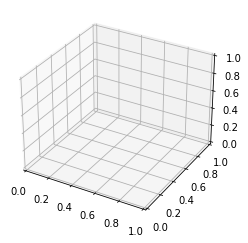

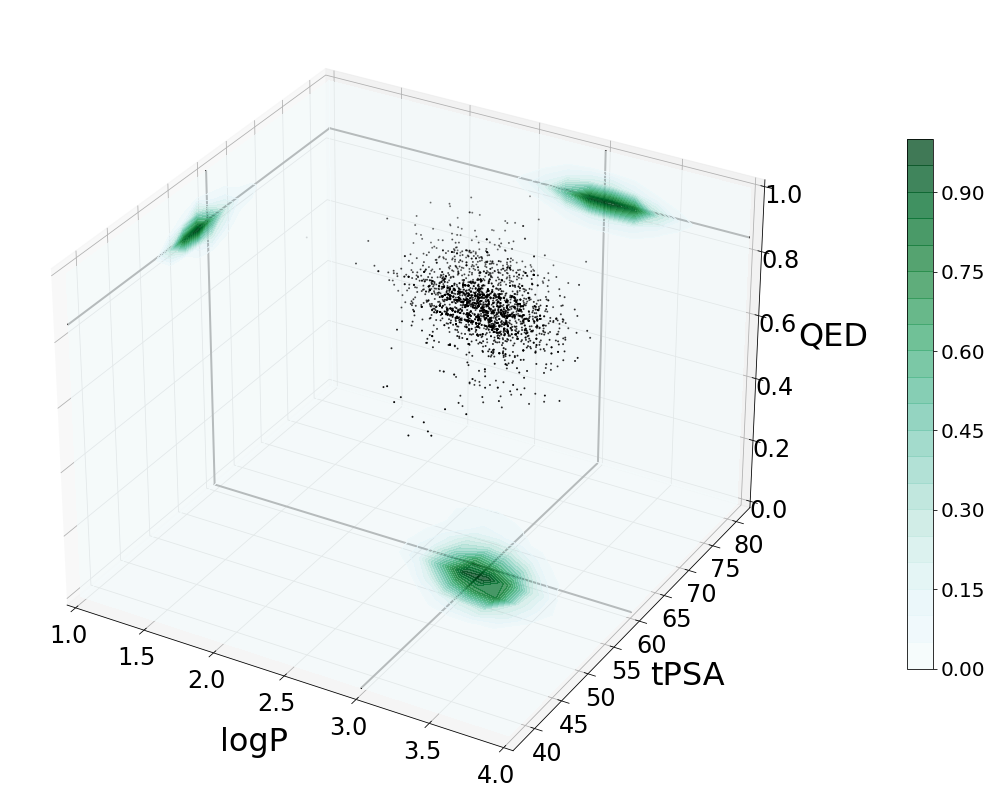

In [35]:
plot3d(['logP', 'tPSA', 'QED'], data=best, trg_p=[3.0, 60.0, 0.85])

In [15]:
best

,logP,tPSA,QED
0,2.8311,55.40,0.850960
1,3.1794,61.36,0.799610
2,2.8530,61.36,0.786072
3,3.0179,61.44,0.829225
4,2.4990,66.48,0.819777
...,...,...,...
986,2.6347,61.27,0.821087
987,3.1794,61.36,0.781960
988,3.2196,55.40,0.846430
989,3.1794,61.36,0.799610


[[ 1.5427      3.5295      3.5295      1.5151      1.6534      3.0805
   2.4746      3.5295      3.2341      1.5495      1.1266      1.6534
   1.4683      3.0894      1.7805      2.4353      1.1266      1.0841
   2.3929      2.5284      2.1102      3.6633      2.0753      2.382
   4.0029      1.9292      1.8465      3.6667      3.2766      1.1117
   1.0403      1.6534      3.6633      1.1266      1.3577      4.2628
   2.0435      1.2578      1.9919      1.5427      1.585       3.4457
   2.0435      2.0197      3.9995      3.1319      3.7832      2.0123
   1.0841      3.2766      3.3191      1.6534      3.2381      2.4306
   2.0328      1.6534      1.7441      3.2766      1.4001      0.9267
   2.2896      4.2628      3.2341      2.0988      2.1102      3.572
   2.4921      1.865       3.6667      2.2523      3.0397      2.0435
   0.9267      2.1561      0.8079      1.6534      2.2896      3.5295
   1.5461      3.5295      1.2374      1.5427      1.5461      3.1285
   2.0435      3.5295 

[1.5789473684210527, 30.894736842105264, 0.7894736842105263]

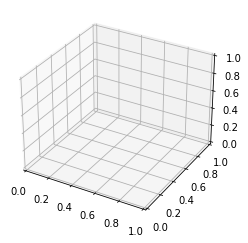

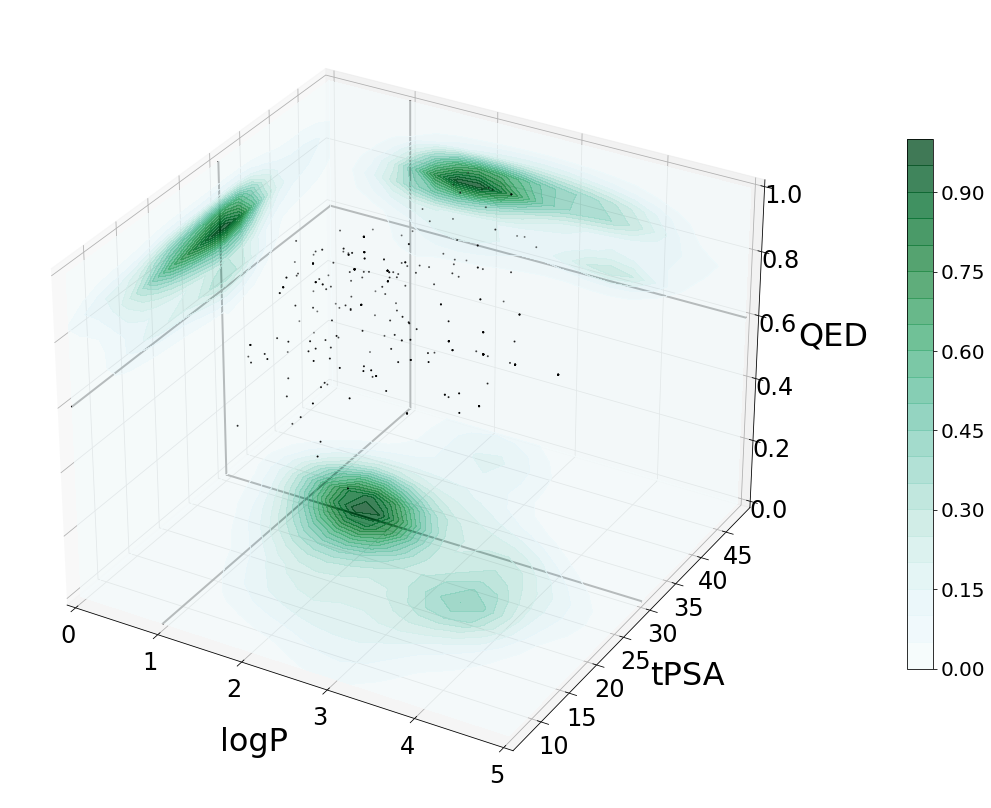

In [39]:
plot3d(['logP', 'tPSA', 'QED'], data=worst, trg_p=[1.0, 30.0, 0.6])

## 畫分子

In [65]:
sid = 74
logp, tpsa, qed = 3.0, 60.0, 0.85

In [62]:
test_scaffolds = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/test_scaffolds_sample.csv')
scaffold = test_scaffolds['scaffold'].iloc[sid]
print(scaffold)

c1ccc(C2CCCC2)cc1


In [75]:
df1 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv31-beta0.01-warmup15000-17/test_scaffolds/s{sid}_p3.0-60.0-0.85_prop.csv', index_col=[0])
df2 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv32-beta0.01-warmup15000-19/test_scaffolds/s{sid}_p3.0-60.0-0.85_prop.csv', index_col=[0])
df3 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv3-beta0.01-warmup15000-17/test_scaffolds/s{sid}_p3.0-60.0-0.85_prop.csv', index_col=[0])

df = ((df1.select_dtypes(include=['float32', 'float64', 'int32', 'int64']) + 
       df1.select_dtypes(include=['float32', 'float64', 'int32', 'int64']) +
       df1.select_dtypes(include=['float32', 'float64', 'int32', 'int64'])) / 3)
df['smiles'] = df1['smiles']
df['scaffold'] = df1['scaffold']

In [77]:
df = df.drop_duplicates('smiles')
df['logP-AE'] = abs(df['logP'] - logp)
df['tPSA-AE'] = abs(df['tPSA'] - tpsa)
df['QED-AE'] = abs(df['QED'] - qed)
df_filtered = df[(df['logP-AE'] <= 0.4) & (df['tPSA-AE'] <= 8) & (df['QED-AE'] <= 0.03)]
df_filtered = df_filtered[df_filtered.scaffold == scaffold]

In [78]:
import itertools

def get_combinations(lst):
    combinations = []
    for r in range(1, len(lst) + 1):
        permutations = itertools.permutations(lst, r)
        combinations.extend(permutations)
    return combinations

prop_mae = get_combinations(['logP-AE', 'tPSA-AE', 'QED-AE'])

cumm = None

for i, mae in enumerate(prop_mae):
    sorted = df_filtered.sort_values(by=list(mae))
    if i == 0:
        cumm = sorted[:3].copy()
    else:
        cumm = pd.concat([cumm, sorted[:3]], axis=0)

In [81]:
cumm = cumm.drop_duplicates('smiles')

In [83]:
from Utils.smiles import plot_smiles

file_name = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/easiest_found/'
for i in range(len(cumm)):
    plot_smiles(smiles=cumm['smiles'].iloc[i],
                save_path=os.path.join(file_name, f'smi{i}.png'), size=(540, 320))
plot_smiles(smiles=cumm['scaffold'].iloc[i],
            save_path=os.path.join(file_name, f'sca.png'))

In [84]:
cumm

,logP,tPSA,QED,smiles,scaffold,logP-MAE,tPSA-MAE,QED-MAE,logP-AE,tPSA-AE,QED-AE
395,2.99990,58.20,0.836224,CC(=O)NCCC(=O)NC1(c2ccc(Br)cc2F)CCCC1,c1ccc(C2CCCC2)cc1,0.00010,1.80,0.013776,0.00010,1.80,0.013776
642,2.99960,61.44,0.856212,CC1CC(NC(=O)CCNC(=O)N(C)C)CC1c1ccc(Cl)cc1,c1ccc(C2CCCC2)cc1,0.00040,1.44,0.006212,0.00040,1.44,0.006212
793,3.00050,57.61,0.871389,CCN(CCO)S(=O)(=O)c1cc(C2CCCC2)ccc1Cl,c1ccc(C2CCCC2)cc1,0.00050,2.39,0.021389,0.00050,2.39,0.021389
261,3.14940,60.03,0.820580,COCC(C)NC(=O)N(C)C1(c2ccc(OC)c(OC)c2)CCCC1,c1ccc(C2CCCC2)cc1,0.14940,0.03,0.029420,0.14940,0.03,0.029420
538,2.62770,60.03,0.831432,COCCN(C)C(=O)NC1CCCC1c1ccc(OC)c(OC)c1,c1ccc(C2CCCC2)cc1,0.37230,0.03,0.018568,0.37230,0.03,0.018568
47,3.11010,60.16,0.852633,CCCS(=O)(=O)c1ccc(N)cc1C1CCCC1,c1ccc(C2CCCC2)cc1,0.11010,0.16,0.002633,0.11010,0.16,0.002633
94,3.17870,55.40,0.849933,COC(=O)CCC(=O)NC1(c2ccc(Cl)cc2)CCCC1,c1ccc(C2CCCC2)cc1,0.17870,4.60,0.000067,0.17870,4.60,0.000067
597,3.16470,55.40,0.850148,CC(C)OC(=O)CNC(=O)c1ccc(F)cc1C1CCCC1,c1ccc(C2CCCC2)cc1,0.16470,4.60,0.000148,0.16470,4.60,0.000148
986,2.75628,62.12,0.849836,N#CCC(=O)NCC#CCOc1ccccc1C1CCCC1,c1ccc(C2CCCC2)cc1,0.24372,2.12,0.000164,0.24372,2.12,0.000164
343,3.11010,60.16,0.852633,CCCS(=O)(=O)c1cc(N)cc(C2CCCC2)c1,c1ccc(C2CCCC2)cc1,0.11010,0.16,0.002633,0.11010,0.16,0.002633


### PSCA-VAETF vs. MolGPT

In [5]:
from Utils.smiles import plot_smiles_group

In [8]:
smiles_list = ['O=C(Cc1ccccc1)NCc1ccccc1',
               'c1cnc2[nH]ccc2c1',
               'c1ccc(-c2ccnnc2)cc1',
               'c1ccc(-n2cnc3ccccc32)cc1',
               'O=C(c1cc[nH]c1)N1CCN(c2ccccc2)CC1']

In [9]:
plot_smiles_group(smiles=smiles_list, 
                  save_path='/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/molgpt_scaffold.png',
                  img_size=(300,500),
                  n_per_mol=5)

TypeError: a bytes-like object is required, not 'SVG'

## Easiest

In [78]:
df1 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv31-beta0.01-warmup15000-17/test_scaffolds/s67_metric.csv')
df2 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv32-beta0.01-warmup15000-19/test_scaffolds/s67_metric.csv')
df3 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv3-beta0.01-warmup15000-17/test_scaffolds/s67_metric.csv')

((df1.select_dtypes(include=['float32', 'float64', 'int32', 'int64']) + 
  df2.select_dtypes(include=['float32', 'float64', 'int32', 'int64']) +
  df3.select_dtypes(include=['float32', 'float64', 'int32', 'int64'])) / 3)

,Unnamed: 0,logP,tPSA,QED,valid,unique,novel,intDiv,sim,SSF,...,logP-MAE,logP-SD,tPSA-MSE,tPSA-MAE,tPSA-SD,QED-MSE,QED-MAE,QED-SD,valid_in_tolerance,unique_in_tolerance
0,0.0,1.0,30.0,0.600,0.900667,0.611766,1.000000,0.681806,0.774653,0.615878,...,0.497851,0.366814,0.986300,5.504627,6.607919,0.153007,0.158992,0.080751,2.000000,2.000000
1,1.0,1.0,30.0,0.725,0.873667,0.595834,0.999349,0.684936,0.796094,0.652281,...,0.488130,0.383400,2.521560,6.660818,7.699075,0.044001,0.071306,0.067431,0.333333,0.333333
2,2.0,1.0,30.0,0.850,0.824000,0.497095,1.000000,0.658089,0.745547,0.570632,...,0.465053,0.391007,4.262900,7.921786,8.573252,-0.027668,0.033026,0.041225,13.333333,9.666667
3,3.0,1.0,60.0,0.600,0.963333,0.684179,0.999553,0.716392,0.917520,0.832119,...,0.286119,0.292632,0.366138,4.642641,5.728514,0.127809,0.140387,0.094169,88.333333,48.000000
4,4.0,1.0,60.0,0.725,0.979667,0.582273,0.998324,0.685472,0.924193,0.851923,...,0.257449,0.277980,0.643769,4.684112,5.664376,0.042718,0.064508,0.063131,150.666667,66.333333
5,5.0,1.0,60.0,0.850,0.976000,0.636015,0.997431,0.715607,0.919947,0.832406,...,0.261830,0.294509,0.625401,4.635665,6.077693,-0.000993,0.033765,0.045658,304.666667,164.666667
6,6.0,1.0,90.0,0.600,0.979000,0.851571,0.997999,0.744174,0.917422,0.814376,...,0.282566,0.310223,-3.195116,5.228144,6.103278,0.060100,0.088197,0.090984,121.000000,97.000000
7,7.0,1.0,90.0,0.725,0.967667,0.849173,0.994322,0.743991,0.887289,0.745829,...,0.274751,0.332205,-2.356345,5.190845,6.292940,-0.003416,0.052319,0.070773,201.333333,167.666667
8,8.0,1.0,90.0,0.850,0.940667,0.858702,0.996615,0.767985,0.868745,0.722748,...,0.317949,0.395162,-2.592403,6.868987,8.803820,-0.035174,0.050296,0.068217,189.333333,153.000000
9,9.0,2.0,30.0,0.600,0.933000,0.781354,0.999547,0.726447,0.883426,0.776334,...,0.306440,0.354711,2.089651,4.954751,6.331622,0.101978,0.121979,0.105137,130.666667,91.333333


In [96]:
df1 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv31-beta0.01-warmup15000-17/test_scaffolds/s67_good.csv')
df2 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv32-beta0.01-warmup15000-19/test_scaffolds/s67_good.csv')
df3 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv3-beta0.01-warmup15000-17/test_scaffolds/s67_good.csv')

((df1 + df2 + df3) / 3).iloc[23]

Unnamed: 0          23.000000
n_good_scaffold    716.000000
n_good_property    441.333333
n_good_both        344.333333
Name: 23, dtype: float64

In [ ]:
df1 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv31-beta0.01-warmup15000-17/test_scaffolds/s9_metric.csv')
df2 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv32-beta0.01-warmup15000-19/test_scaffolds/s9_metric.csv')
df3 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv3-beta0.01-warmup15000-17/test_scaffolds/s9_metric.csv')

((df1.select_dtypes(include=['float32', 'float64', 'int32', 'int64']) + 
  df2.select_dtypes(include=['float32', 'float64', 'int32', 'int64']) +
  df3.select_dtypes(include=['float32', 'float64', 'int32', 'int64'])) / 3)

In [97]:
df1 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv31-beta0.01-warmup15000-17/test_scaffolds/s9_good.csv')
df2 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv32-beta0.01-warmup15000-19/test_scaffolds/s9_good.csv')
df3 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv3-beta0.01-warmup15000-17/test_scaffolds/s9_good.csv')

((df1 + df2 + df3) / 3).iloc[0]

Unnamed: 0         0.000000
n_good_scaffold    0.000000
n_good_property    0.666667
n_good_both        0.000000
Name: 0, dtype: float64

### PSCA-VAETF vs. MolGPT

In [ ]:
avg_molgpt = get_average_metric_from_all_models(datatype='molgpt', molgpt=True)

In [93]:
avg_molgpt.groupby('scaffold').mean().reset_index()

,scaffold,logP,tPSA,SAS,valid,unique,novel,intDiv,sim,SSF,...,logP-SD,tPSA-MSE,tPSA-MAE,tPSA-SD,SAS-MSE,SAS-MAE,SAS-SD,valid_in_tolerance,unique_in_tolerance,HAC
0,O=C(Cc1ccccc1)NCc1ccccc1,2.0,60.0,2.75,0.679950,0.426301,1.000000,0.651170,0.999999,0.999995,...,0.283797,-3.595076,6.611642,6.927400,-0.252443,0.335132,0.228558,2686.166667,1263.875000,17.0
1,O=C(c1cc[nH]c1)N1CCN(c2ccccc2)CC1,2.0,60.0,2.75,0.837817,0.194022,0.998837,0.556632,0.999279,0.995338,...,0.286943,-2.395676,5.910043,6.844441,-0.026774,0.252352,0.205949,3286.375000,592.083333,19.0
2,c1ccc(-c2ccnnc2)cc1,2.0,60.0,2.75,0.651233,0.553817,1.000000,0.706997,0.997755,0.986404,...,0.252767,1.327648,5.852148,5.898832,0.062707,0.270739,0.180528,2580.375000,1454.833333,12.0
3,c1ccc(-n2cnc3ccccc32)cc1,2.0,60.0,2.75,0.617117,0.476919,1.000000,0.658077,0.998446,0.991959,...,0.291432,-2.659654,5.973154,7.209858,-0.180120,0.303490,0.219498,2752.041667,1054.875000,15.0
4,c1cnc2[nH]ccc2c1,2.0,60.0,2.75,0.593804,0.634168,1.000000,0.724964,0.997393,0.971726,...,0.266005,0.691708,4.592567,5.452897,0.181766,0.304934,0.185948,1984.125000,1544.500000,9.0


### 畫有該 scaffold 的分子性質和 scaffold test set 分子性質

In [234]:
import seaborn as sns

In [133]:
df1 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv31-beta0.01-warmup15000-17/test_scaffolds/s67_metric.csv')
df2 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv32-beta0.01-warmup15000-19/test_scaffolds/s67_metric.csv')
df3 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv3-beta0.01-warmup15000-17/test_scaffolds/s67_metric.csv')

n_compliant = (df1.select_dtypes(include=['float32', 'float64', 'int32', 'int64']) + 
               df2.select_dtypes(include=['float32', 'float64', 'int32', 'int64']) +
               df3.select_dtypes(include=['float32', 'float64', 'int32', 'int64'])) / 3

In [134]:
best_case_scaffold = 'c1ccc2c(c1)CCS2'
df = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/test_scaffolds.csv', index_col=[0])
df = df[df.scaffold == best_case_scaffold]

In [135]:
train = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/train.csv', index_col=[0])
train = train.sample(n=100000)

In [257]:
def get_data(s):
    df1 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv31-beta0.01-warmup15000-17/test_scaffolds/s{s}_metric.csv')
    df2 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv32-beta0.01-warmup15000-19/test_scaffolds/s{s}_metric.csv')
    df3 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv3-beta0.01-warmup15000-17/test_scaffolds/s{s}_metric.csv')
    scaffold = df1['scaffold'][0]
    n_compliant = (df1.select_dtypes(include=['float32', 'float64', 'int32', 'int64']) + 
                   df2.select_dtypes(include=['float32', 'float64', 'int32', 'int64']) +
                   df3.select_dtypes(include=['float32', 'float64', 'int32', 'int64'])) / 3
    scaffold_dist = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/test_scaffolds.csv', index_col=[0])
    scaffold_dist = scaffold_dist[scaffold_dist.scaffold == scaffold]
    print('scaffold:', scaffold)
    print('# in the scaffold test set:', len(scaffold_dist))
    return n_compliant, scaffold_dist

In [280]:
width = [0.5, 7, 0.05]
property_name = ['logP', 'tPSA', 'QED']
property_dict = {
    'logP': (-2, 6),
    'tPSA': (0, 120),
    'QED': (0.2, 1)
}


def plot(train, df, n_compliant):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16.5, 4.5))

    for i in range(len(axes)):
        t = sns.kdeplot(data=train.loc[:, property_name[i]], ax=axes[i],
                        shade=True, linewidth=2,
                        color='red', legend=False, label=axes[i])

        d = sns.kdeplot(data=df.loc[:, property_name[i]], ax=axes[i],
                        shade=True, linewidth=2,
                        color='blue', legend=False, label=axes[i])
        axes[i].set_xlim(left=property_dict[property_name[i]][0], right=property_dict[property_name[i]][1])
        axes[i].set_xlabel(xlabel=property_name[i], fontsize=17)
        axes[i].set_ylabel(ylabel='Density', fontsize=17)
        axes[i].tick_params(axis="both", which="major", labelsize=13)
        
        ax2 = axes[i].twinx()
        ax2.set_xlim(left=property_dict[property_name[i]][0], right=property_dict[property_name[i]][1])
        ax2.set_ylabel(ylabel='# condition-compliant (unique)', fontsize=17)
        ax2.tick_params(axis="both", which="major", labelsize=13)

        tmp = n_compliant.groupby(property_name[i]).mean().reset_index()
        x = tmp[property_name[i]]
        y = tmp['unique_in_tolerance']
        ax2.bar(x, y, width=width[i], alpha=0.75, color='orange')
        for i in range(len(x)):
            ax2.plot([x[i], x[i]], [0, y.max()], color='gray', linestyle='dashed')

    # Add legends for each plot
    legend_handles = [plt.Line2D([], [], color='red', label='Train'),
                    plt.Line2D([], [], color='blue', label='Scaffold')]

    # Create separate legends for each subplot
    axes[0].legend(handles=legend_handles, loc='upper left', fontsize=16)
    axes[1].legend(handles=legend_handles, loc='upper left', fontsize=16)
    axes[2].legend(handles=legend_handles, loc='upper left', fontsize=16)

    fig.tight_layout()


scaffold: O=C(Nc1ccccc1)c1ncoc1-c1ccco1
# in the scaffold test set: 85


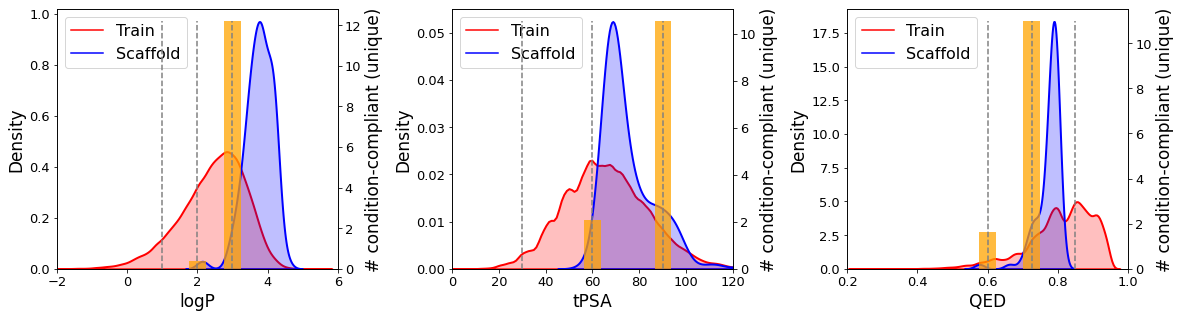

In [258]:
s = 12
# s = 74

n_compliant, scaffold_dist = get_data(s)
plot(train, scaffold_dist, n_compliant)

scaffold: c1ccc(C2CCCC2)cc1
# in the scaffold test set: 522


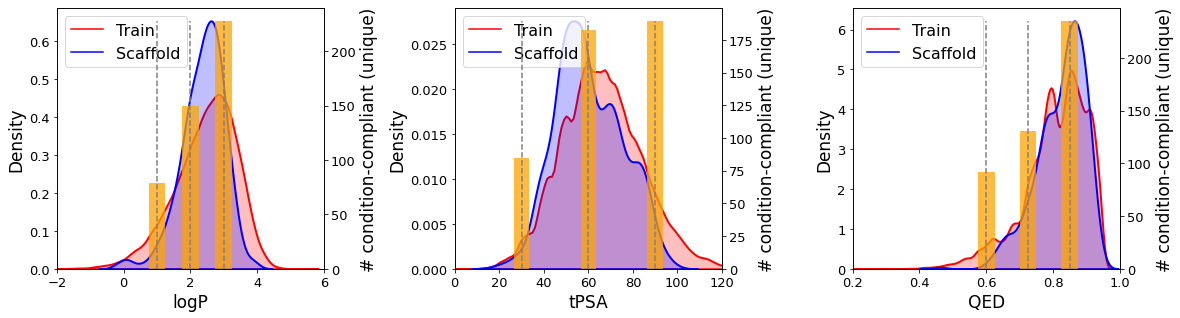

In [259]:
s = 74

n_compliant, scaffold_dist = get_data(s)
plot(train, scaffold_dist, n_compliant)

scaffold: O=c1[nH]nc2n1CCNC2
# in the scaffold test set: 107


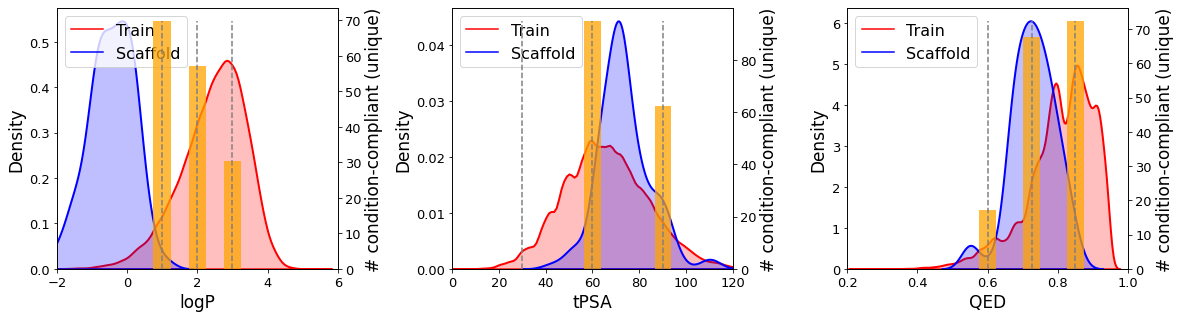

In [281]:
# s = 80
s = 83

n_compliant, scaffold_dist = get_data(s)
plot(train, scaffold_dist, n_compliant)

In [410]:
from rdkit.Chem import Descriptors, MolFromSmiles

In [411]:
def compute_properties(smiles):
    mol = MolFromSmiles(smiles)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    qed = Descriptors.qed(mol)
    return logp, tpsa, qed

In [412]:
def get_data(s):
    trg_prop_list = get_trg_prop_list()
    cumm = None
    for file_name in ('scacvaetfv31-beta0.01-warmup15000-17',
                      'scacvaetfv32-beta0.01-warmup15000-19',
                      'scacvaetfv3-beta0.01-warmup15000-17'):
        for trg in trg_prop_list:
            df = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/{file_name}'
                            f'/test_scaffolds/s{s}_p{trg[0]}-{trg[1]}-{trg[2]}_prop.csv', index_col=[0])
            if cumm is not None:
                cumm = pd.concat([cumm, df], axis=0)
            else:
                cumm = df
    df2 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/scacvaetfv32-beta0.01-warmup15000-19/test_scaffolds/s{s}_metric.csv')
    scaffold = df2['scaffold'][0]
    prop = compute_properties(scaffold)
    scaffold_dist = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/test_scaffolds.csv', index_col=[0])
    scaffold_dist = scaffold_dist[scaffold_dist.scaffold == scaffold]
    print('scaffold:', scaffold)
    print('# in the scaffold test set:', len(scaffold_dist))
    print(prop)
    return cumm, scaffold_dist

scaffold: O=c1[nH]nc2n1CCNC2
# in the scaffold test set: 107


In [413]:
property_name = ['logP', 'tPSA', 'QED']
property_dict = {
    'logP': (-2, 6),
    'tPSA': (0, 120),
    'QED': (0.2, 1)
}


def plot(train, scaffold_dist, gen):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4.3))

    for i in range(len(axes)):
        sns.kdeplot(data=train.loc[:, property_name[i]], ax=axes[i],
                        shade=True, linewidth=2,
                        color='red', legend=False, label=axes[i])

        sns.kdeplot(data=scaffold_dist.loc[:, property_name[i]], ax=axes[i],
                        shade=True, linewidth=2,
                        color='blue', legend=False, label=axes[i])

        sns.kdeplot(data=gen.loc[:, property_name[i]], ax=axes[i],
                        shade=True, linewidth=2,
                        color='orange', legend=False, label=axes[i])

        axes[i].set_xlim(left=property_dict[property_name[i]][0], right=property_dict[property_name[i]][1])
        axes[i].set_xlabel(xlabel=property_name[i], fontsize=17)
        axes[i].set_ylabel(ylabel='Density', fontsize=17)
        axes[i].tick_params(axis="both", which="major", labelsize=13)
        
        for j in range(len(x)):
            axes[i].axvline(x=trg_prop_settings[property_name[i]][j],
                            linestyle='--', color='gray')

    # # Add legends for each plot
    # legend_handles = [plt.Line2D([], [], color='red', label='Train'),
    #                   plt.Line2D([], [], color='blue', label='Scaffold test'),
    #                   plt.Line2D([], [], color='orange', label='Gen')]

    # # Create separate legends for each subplot
    # axes[0].legend(handles=legend_handles, loc='lower left', fontsize=15)
    # axes[1].legend(handles=legend_handles, loc='lower left', fontsize=15)
    # axes[2].legend(handles=legend_handles, loc='lower left', fontsize=15)

    fig.tight_layout()

    legend_handles = [
        plt.Line2D([], [], color='red', label='Train'),
        plt.Line2D([], [], color='blue', label='Scaffold test'),
        plt.Line2D([], [], color='orange', label='Gen')
    ]
    fig.legend(handles=legend_handles, loc='lower center', ncol=3, fontsize=16, bbox_to_anchor=(0.5, -0.13))


scaffold: O=c1[nH]nc2n1CCNC2
# in the scaffold test set: 107
(-1.3254000000000001, 62.71, 0.46927282235000184)


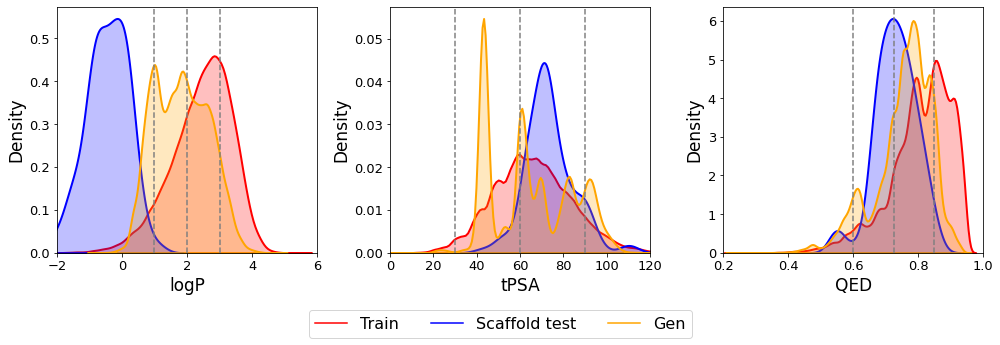

In [414]:
cumm, scaffold_dist = get_data(s=83)
plot(train, scaffold_dist, cumm)

scaffold: c1ccc(-n2ccc(-c3ccco3)n2)cc1
# in the scaffold test set: 87
(3.1323000000000016, 30.96, 0.6502213437191051)


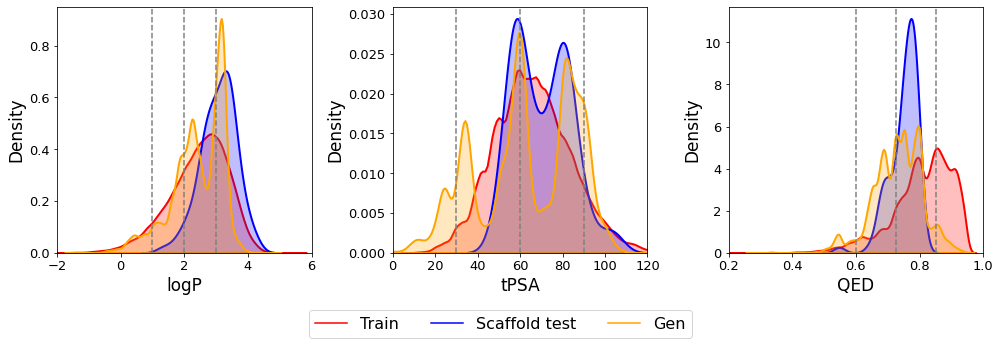

In [415]:
cumm, scaffold_dist = get_data(s=51)
plot(train, scaffold_dist, cumm)